# 課題4: プロ野球選手の年俸データのクラスタリング

ここでは、k-means法を利用したクラスタリングの理解を深めて頂くための課題を用意しました。Lesson6で使用したプロ野球選手の推定年俸のデータを使い、クラスタリングを行ってください。なお、クラスタリングはデータを正規化したうえで行ないます。

わからない場合は、ここまでのレッスン内容や各種ライブラリの公式ドキュメントを参照しましょう。

## 1. ライブラリのimport

In [1]:
# （変更しないでください）

# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# データの正規化
from sklearn.preprocessing import MinMaxScaler

# k-means法
from sklearn.cluster import KMeans

# シルエットプロット
from sklearn.metrics import silhouette_score, silhouette_samples

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

# seabornによる装飾を適用する
sns.set_theme()

## 2. データの読み込み

CSVファイル *baseball_salary.csv* を読み込み、dataset_baseに格納します。

In [2]:
# CSVファイルを読み込んでdataset_baseに格納する
dataset_base = pd.read_csv('baseball_salary.csv')

In [3]:
# dataset_baseの最初の5行を表示
dataset_base.head()

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,打率,試合,打席数,打数,安打,本塁打,打点,盗塁,四球,死球,三振,犠打,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,0.308,143,651,556,171,23,92,13,83,4,113,2,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,0.271,138,629,565,153,14,56,8,32,1,107,30,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,0.290,143,679,565,164,8,60,35,89,15,120,6,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,0.265,116,405,344,91,27,78,0,50,8,111,0,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,0.292,100,288,243,71,9,48,2,40,1,56,0,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


In [4]:
# dataset_baseから「打率、打点」列を抜き出してdatasetに格納する
dataset = dataset_base[['打率', '打点']].copy()

# 列名を、打率は「batting」、打点は「points」にリネームする
dataset = dataset.rename(columns={'打率': 'batting', '打点': 'points'})

# datasetの先頭の5行を表示
dataset.head()

,batting,points
0,0.308,92
1,0.271,56
2,0.290,60
3,0.265,78
4,0.292,48


## 3. データの正規化

クラスタリングは類似度（距離）に基づいて行なわれるため、データの範囲に差がある場合は正規化を行ないます。

ここでは、Lesson5のデータの前処理で紹介した *Min-max normalization* を使ってみましょう。 `sklearn.preprocessing.MinMaxScaler()` を利用します。

参考：https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [5]:
# MinMaxScalerで正規化を実施し、その結果を変数tempに格納する
scaler = MinMaxScaler()
temp = scaler.fit_transform(dataset)

In [6]:
# 正規化後のデータの先頭の5行を表示
print(temp[:5])

[[0.616      0.87619048]
 [0.542      0.53333333]
 [0.58       0.57142857]
 [0.53       0.74285714]
 [0.584      0.45714286]]


In [7]:
# tempの0列目を「batting_scaled」、1列目を「points_scaled」という列名にして、datasetへ列として追加
dataset['batting_scaled'] = temp[:, 0]
dataset['points_scaled'] = temp[:, 1]

In [8]:
# 改めてdatasetの先頭の5行を表示
dataset.head()

,batting,points,batting_scaled,points_scaled
0,0.308,92,0.616,0.876190
1,0.271,56,0.542,0.533333
2,0.290,60,0.580,0.571429
3,0.265,78,0.530,0.742857
4,0.292,48,0.584,0.457143


## 4. データの可視化

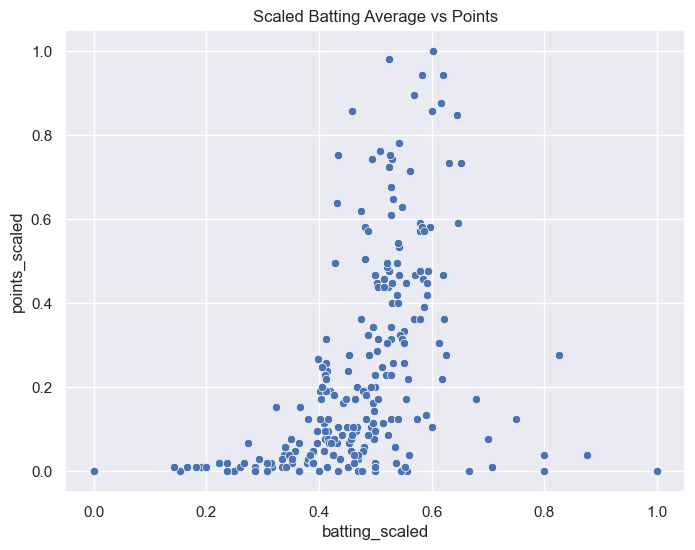

In [9]:
# 正規化後の打率と打点の散布図を描画する
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dataset, x='batting_scaled', y='points_scaled')

# グラフのタイトルを設定
plt.title('Scaled Batting Average vs Points')
plt.show()


## 5. クラスター数の決定

エルボーメソッドとシルエットプロットを使用してクラスター数を決定しましょう

### クラスタリングを行なうデータの抽出

In [10]:
# datasetからbatting_scaledとpoints_scaledを取り出して、numpy配列に変換してXに格納する
X = dataset[['batting_scaled', 'points_scaled']].values

# Xの形状を確認
X.shape

(241, 2)

### エルボーメソッド

In [11]:
# 最大クラスター数を10として、クラスター数1から10までのWCSS値を算出（変更しないでください）
wcss = []
c_list = np.arange(1, 11)

In [13]:
# クラスタ数の算出
for i in c_list:
    # n_clustersを1から10まで変化させてKMeansを実行
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    # WCSS値（inertia_）をリストに追加
    wcss.append(kmeans.inertia_)


In [14]:
# WCSSの表示（変更しないでください）
wcss

[19.166235457325396,
 7.410516705251341,
 5.278730811205743,
 3.832835181503003,
 2.6096634269518493,
 2.178804914252078,
 1.6806578975971245,
 1.4198474369987677,
 1.2978067461257048,
 1.1072149445460484]

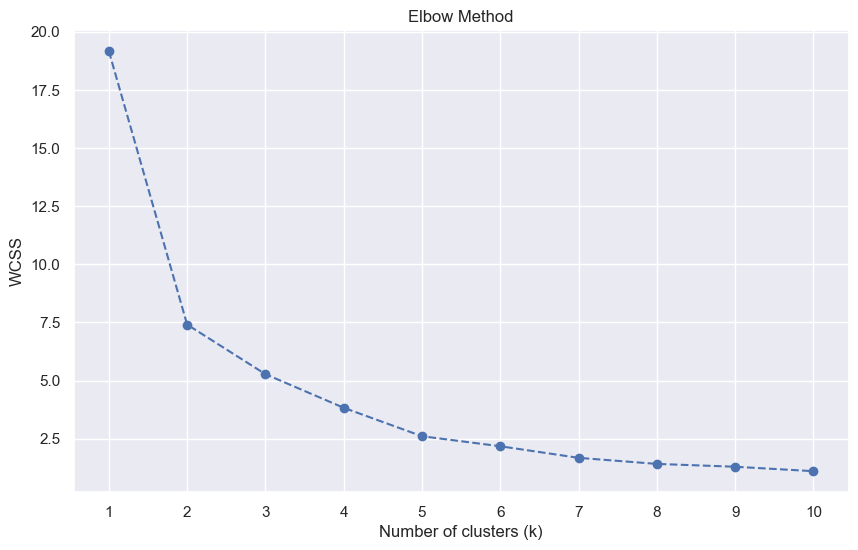

In [15]:
# エルボーメソッドのグラフの表示
plt.figure(figsize=(10, 6))
plt.plot(c_list, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(c_list)
plt.show()

### シルエットプロット

In [16]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

In [17]:
# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
kmeans = KMeans(n_clusters=cluster_no, init='k-means++', random_state=42)
y_km = kmeans.fit_predict(X)

In [18]:
# シルエットスコアの平均値
silhouette_avg = silhouette_score(X, y_km)
print(f'シルエットスコア平均: {silhouette_avg:.3f}')

# 各データのシルエットスコア
sample_silhouette_values = silhouette_samples(X, y_km)

シルエットスコア平均: 0.425


C:\Users\kwata\AppData\Local\Temp\ipykernel_11092\2027359437.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap("Spectral")(float(i) / cluster_no)


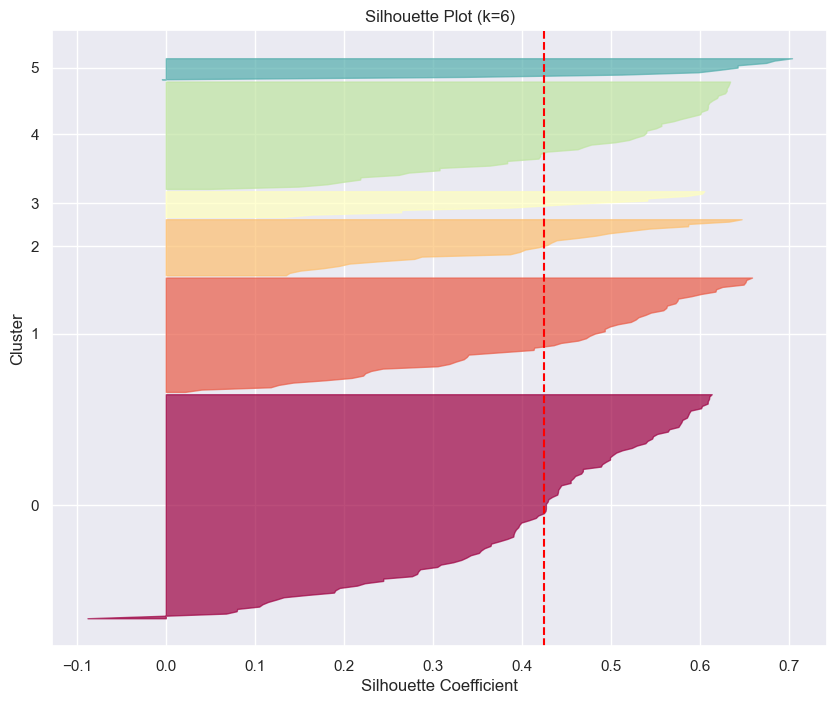

In [21]:
# シルエットプロットを描画
y_ax_lower, y_ax_upper = 0, 0
yticks = []

plt.figure(figsize=(10, 8))

for i in range(cluster_no):
    # 特定のクラスタのスコアを抽出してソート
    ith_cluster_silhouette_values = sample_silhouette_values[y_km == i]
    ith_cluster_silhouette_values.sort()
    
    y_ax_upper += len(ith_cluster_silhouette_values)
    color = plt.cm.get_cmap("Spectral")(float(i) / cluster_no)
    
    # 横向きの棒グラフ（領域）を描画
    plt.fill_betweenx(np.arange(y_ax_lower, y_ax_upper), 0,
                      ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    
    # クラスタラベルの表示位置を計算
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(ith_cluster_silhouette_values)

# 全体の平均スコアに点線を引く
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.title('Silhouette Plot (k=6)')
plt.ylabel('Cluster')
plt.xlabel('Silhouette Coefficient')
plt.yticks(yticks, np.arange(cluster_no))
plt.show()

## 6. 結果の確認

上記の結果をもとに、クラスタ数6で再度クラスタリングを実行し、分類ごとに色を分けて散布図にプロットしましょう。

In [22]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
kmeans = KMeans(n_clusters=cluster_no, init='k-means++', random_state=42)
# 学習と予測を同時に行い、各データのクラスタ番号を取得する
y_km = kmeans.fit_predict(X)

# 分類結果をdatasetの新しい列「cluster」として保存
dataset['cluster'] = y_km

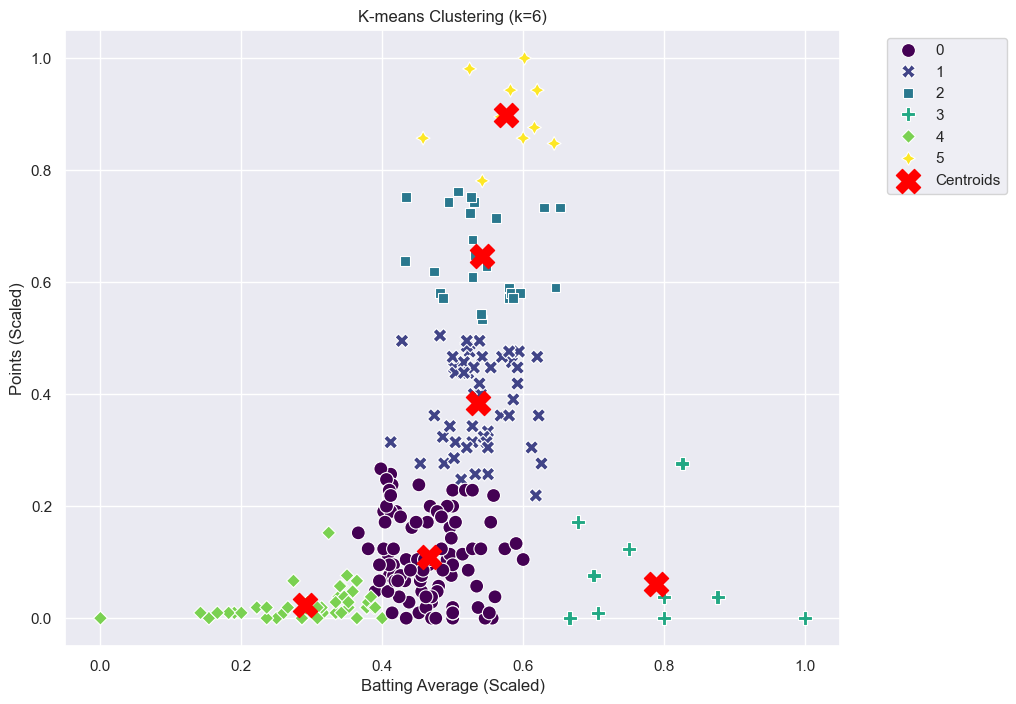

In [23]:
# k-means法によるクラスタリングの結果を描画
plt.figure(figsize=(10, 8))

# クラスタごとに色を分けてプロット
# hueに'cluster'を指定することで自動的に色分けされる
sns.scatterplot(data=dataset, x='batting_scaled', y='points_scaled', 
                hue='cluster', palette='viridis', s=100, style='cluster')

# 各クラスタの中心点（重心）をプロットする
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title(f'K-means Clustering (k={cluster_no})')
plt.xlabel('Batting Average (Scaled)')
plt.ylabel('Points (Scaled)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()